In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(torch.cuda.get_device_name(0))

In [ ]:
# %%
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, BatchSampler
import matplotlib.pyplot as plt
import os

In [ ]:
class GRUNet(nn.Module):
    def __init__(self, mfg):
        """
        GRUNet model for return prediction
        mfg: model config file
        """
        super(GRUNet, self).__init__()


        self.hidden_dim = mfg.hidR
        self.n_layers = mfg.layer_nums
        self.input_dim = mfg.feature_nums
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(self.hidden_dim)
        self.fc = nn.Linear(self.hidden_dim, 1)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.fc(out)
        return out

class Combined_GRUNet(nn.Module):
    def __init__(self, mfg, pretrained_net=None):
        """
        GRUNet model for return prediction
        mfg: model config file
        """
        super(Combined_GRUNet, self).__init__()


        self.hidden_dim = mfg.hidR
        self.n_layers = mfg.layer_nums
        self.input_dim = mfg.feature_nums
        self.pretrain_net = pretrained_net
        self.gru = nn.GRU(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True)
        self.bn = nn.BatchNorm1d(self.hidden_dim)
        self.fc = nn.Linear(self.hidden_dim, 1)

    def forward(self, x, x_lf):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.bn(out)
        out = self.fc(out)
        out_lf = self.pretrain_net(x_lf)
        return out + out_lf

In [ ]:
# %%
# Loading data
import numpy as np
x_train_1d = 100*np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/x_train_1d.npy', allow_pickle=True)
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/y_train.npy', allow_pickle=True)
idx_train = np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/idx_train.npy', allow_pickle=True)

# %%


In [ ]:
x_val_1d = 100*np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/x_val_1d.npy', allow_pickle=True)
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/y_val.npy', allow_pickle=True)
val_label = np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/idx_val.npy', allow_pickle=True)
val_code = np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/code_val.npy', allow_pickle=True)

In [ ]:
# %%

class TimeseriesDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return self.X.__len__()

    def __getitem__(self, index):
        return self.X[index], self.y[index]

class MultiTimeseriesDataset(Dataset):
    def __init__(self, X1: np.ndarray,  X2: np.ndarray,y: np.ndarray):
        self.X1 = torch.tensor(X1).float()
        self.X2 = torch.tensor(X2).float()
        self.y = torch.tensor(y).float()

    def __len__(self):
        return self.X1.__len__()

    def __getitem__(self, index):
        return self.X1[index], self.X2[index], self.y[index]

In [ ]:

class corr_loss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def cov(self, x, y):
        assert x.shape[0] == y.shape[0]
        return (x - x.mean()).squeeze()@(y - y.mean()).squeeze()

    def forward(self, y, y_pred):
        return -(self.cov(y, y_pred)/torch.sqrt(self.cov(y, y)*self.cov(y_pred, y_pred)))


In [ ]:

# Configuration file for 1d gru
class lf_config: pass
lf_mfg = lf_config()
lf_mfg.layer_nums = 2
lf_mfg.hidR = 32
lf_mfg.feature_nums = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_1d = GRUNet(lf_mfg).to(device)
# Define loss function and optimizer
criterion = corr_loss()
optimizer = torch.optim.Adam(model_1d.parameters(), lr=1e-5)
train_dataset = TimeseriesDataset(x_train_1d, y_train)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_dataset = TimeseriesDataset(x_val_1d, y_val)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, num_workers=2)

In [ ]:

# Train daily frequency model
num_epochs = 500
train_losses = []
val_losses = []
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    # Training loop
    model_1d.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model_1d(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader))

    # Validation loop
    model_1d.eval()
    with torch.no_grad():
        val_loss = 0
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_outputs = model_1d(x_val)
            val_loss += criterion(val_outputs, y_val).item()
    current_val_loss = val_loss / len(val_loader)
    val_losses.append(current_val_loss)

    # Save the best model
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss

        model_save_path = '/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/models/model_gru_1d_tpphrm_2_4.pth'
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

        # Now you can safely save your model
        torch.save(model_1d.state_dict(), model_save_path)
        #torch.save(model_1d.state_dict(), './models/model_gru_1d_tpphrm.pth')

    # Early stopping condition
    if epoch > 0 and val_losses[-1] > val_losses[-2]:
        early_stop_counter += 1
    else:
        early_stop_counter = 0
    if early_stop_counter == 5:
        print("Early stopping triggered.")
        break

    if (epoch+1) % 10 == 0:
      print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')








Epoch 10, Train Loss: -0.0052, Val Loss: -0.0034
Epoch 20, Train Loss: -0.0122, Val Loss: -0.0034
Epoch 30, Train Loss: -0.0173, Val Loss: 0.0011
Epoch 40, Train Loss: -0.0221, Val Loss: -0.0021
Epoch 50, Train Loss: -0.0289, Val Loss: -0.0023
Epoch 60, Train Loss: -0.0346, Val Loss: 0.0022
Epoch 70, Train Loss: -0.0378, Val Loss: 0.0015
Epoch 80, Train Loss: -0.0430, Val Loss: 0.0039
Epoch 90, Train Loss: -0.0478, Val Loss: 0.0037
Epoch 100, Train Loss: -0.0501, Val Loss: 0.0016
Epoch 110, Train Loss: -0.0522, Val Loss: 0.0033
Epoch 120, Train Loss: -0.0546, Val Loss: -0.0016
Epoch 130, Train Loss: -0.0564, Val Loss: 0.0009
Epoch 140, Train Loss: -0.0595, Val Loss: -0.0034
Epoch 150, Train Loss: -0.0622, Val Loss: -0.0028
Epoch 160, Train Loss: -0.0641, Val Loss: -0.0082
Epoch 170, Train Loss: -0.0658, Val Loss: -0.0044
Epoch 180, Train Loss: -0.0680, Val Loss: -0.0055
Epoch 190, Train Loss: -0.0715, Val Loss: -0.0096
Epoch 200, Train Loss: -0.0728, Val Loss: -0.0115
Epoch 210, Train 

In [ ]:
np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/y_val.npy', allow_pickle=True)

array([ 0.02874604,  0.00663629, -0.00798053, ..., -0.02670224,
        0.00411524, -0.01229518])

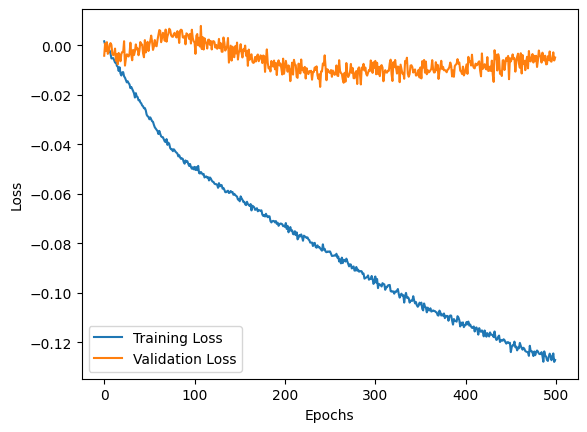

In [ ]:
# Plotting the training and validation loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#%%
# Configuration file for 1d gru
class lf_config: pass
lf_mfg = lf_config()
lf_mfg.layer_nums = 2
lf_mfg.hidR = 32
lf_mfg.feature_nums = 5

model_1d = GRUNet(lf_mfg)

In [ ]:

state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/models/model_gru_1d_tpphrm_2_4.pth')
model_1d.load_state_dict(state_dict)  # Make sure model_1d is your model instance


<All keys matched successfully>

In [ ]:
x_test_1d = 100*np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/x_test_1d.npy', allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/y_test.npy', allow_pickle=True)
test_label = np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/idx_test.npy', allow_pickle=True)
test_code = np.load('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/data_4/code_test.npy', allow_pickle=True)

In [ ]:
# %%
x_val_1d = torch.from_numpy(x_val_1d).float()
x_test_1d = torch.from_numpy(x_test_1d).float()


with torch.no_grad():
    y_pred_test = model_1d(x_test_1d).numpy().ravel()
    y_pred_val = model_1d(x_val_1d).numpy().ravel()



In [ ]:
test_res = pd.DataFrame(np.array([test_label.tolist(), test_code.tolist(), y_pred_test.tolist()]).T, columns=['date', 'code', 'fac'])
test_obs = pd.DataFrame(np.array([test_label.tolist(), test_code.tolist(), y_test.tolist()]).T, columns=['date', 'code', 'fac'])


In [ ]:
val_res = pd.DataFrame(np.array([val_label.tolist(), val_code.tolist(), y_pred_val.tolist()]).T, columns=['date', 'code', 'fac'])

In [ ]:
test_res

,date,code,fac
0,2023-03-24,4151.T,0.3170429468154907
1,2023-03-27,4151.T,0.40060877799987793
2,2023-03-28,4151.T,0.3895665109157562
3,2023-03-29,4151.T,0.32348695397377014
4,2023-03-30,4151.T,0.3230416774749756
...,...,...,...
8573,2024-02-22,4887.T,0.006098717451095581
8574,2024-02-26,4887.T,-0.07002298533916473
8575,2024-02-27,4887.T,-0.006663292646408081
8576,2024-02-28,4887.T,-0.03929451107978821


In [ ]:
test_obs

,date,code,fac
0,2023-03-24,4151.T,-0.0028188783576761
1,2023-03-27,4151.T,0.0141342344760475
2,2023-03-28,4151.T,0.0003485180329596
3,2023-03-29,4151.T,0.0031347869711666
4,2023-03-30,4151.T,-0.0024306350680929
...,...,...,...
8573,2024-02-22,4887.T,-0.0032127098326145
8574,2024-02-26,4887.T,-0.0127226322498021
8575,2024-02-27,4887.T,-0.0103093176923858
8576,2024-02-28,4887.T,-0.00104161070237


In [ ]:
#%%
test_res['fac'] = pd.to_numeric(test_res['fac'], errors='coerce').fillna(0)
val_res['fac'] = pd.to_numeric(val_res['fac'], errors='coerce').fillna(0)
test_obs['fac'] = pd.to_numeric(test_obs['fac'], errors='coerce').fillna(0)

test_res_pivot = test_res.pivot(index='date', columns='code', values='fac').fillna(0)
test_obs_pivot = test_obs.pivot(index='date', columns='code', values='fac').fillna(0)
ic = test_res_pivot.corrwith(test_obs_pivot).mean()

# Prediction cross-section IC
print(f"Predicted cross-section IC: {ic:.4f}")


Predicted cross-section IC: 0.0306


In [ ]:
test_res.to_csv('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/test_res_2_4.csv')
val_res.to_csv('/content/drive/MyDrive/Colab Notebooks/equity and QT final project/GRU model/val_res_2_4.csv')

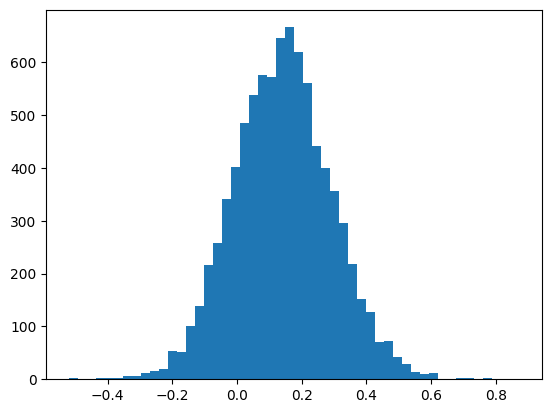

In [ ]:
plt.hist(val_res['fac'], bins=50)
plt.show()